# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.80,0.10,0.10))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [02:06, 33.40 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 106 images in './outputgrayscale/test/gray_cataract'.
There are 0 directories and 108 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 103 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 111 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 104 images in './outputgrayscale/val/gray_cataract'.
There are 0 directories and 107 images in './outputgrayscale/val/gray_normal'.
There are 0 directories and 101 images in './outputgrayscale/val/gray_glaucoma'.
There are 0 directories and 109 images in './outputgrayscale/val/gray_diabetic_retinopathy'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 838 images in './outputgrayscale/train/gr

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    # preprocessing.RandomRotation(0.2),
    # preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [7]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

In [8]:
def sharpen_image(image, factor=1.5):
    adjusted = tf.image.adjust_contrast(image, factor)
    return adjusted

# **Batch size: 16**

In [9]:
epoch = 20
batchsize = 16

In [10]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
# class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


In [11]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [12]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 2s 0us/step


In [13]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                             

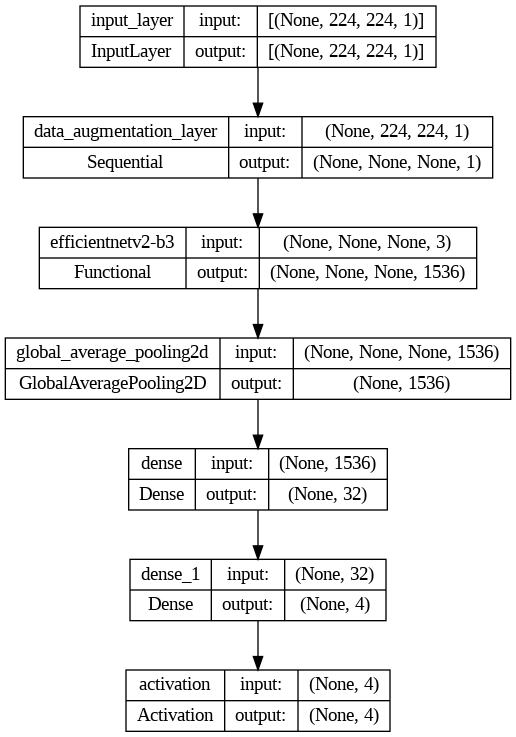

In [14]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [15]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [16]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 119s 493ms/step - loss: 0.6522 - accuracy: 0.7321 - val_loss: 0.5258 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 81s 380ms/step - loss: 0.5019 - accuracy: 0.8038 - val_loss: 0.5021 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 71s 334ms/step - loss: 0.4576 - accuracy: 0.8238 - val_loss: 0.4524 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 68s 318ms/step - loss: 0.4307 - accuracy: 0.8309 - val_loss: 0.4666 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 57s 270ms/step - loss: 0.3973 - accuracy: 0.8433 - val_loss: 0.5024 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 53s 249ms/step - loss: 0.3860 - accuracy: 0.8560 - val_loss: 0.4596 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 7/20
212/212 [==============================]

EfficientNetV2B3 Evaluation

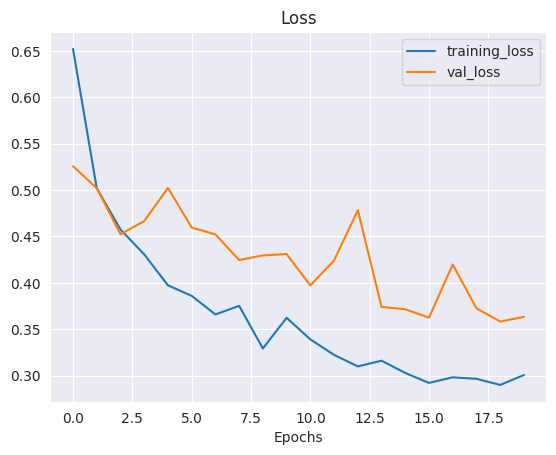

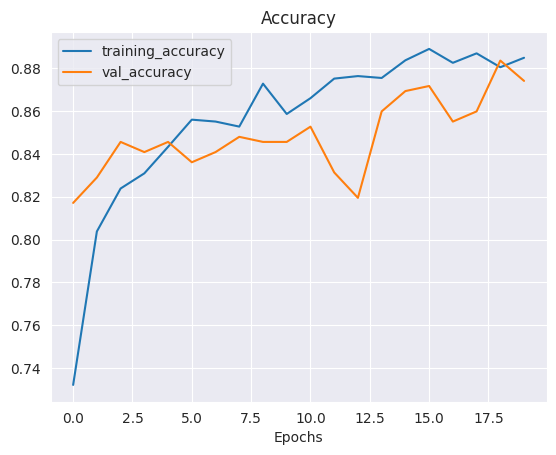

In [17]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       106
           1       0.96      0.99      0.98       111
           2       0.88      0.72      0.79       103
           3       0.81      0.95      0.88       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.281437125748503, 0.34591194968553457, 0.20903954802259886, 0.3169230769230769]
Mean Squared Error: : 0.11330157518386841
The average AUC-ROC is 0.9806621840744506


[0.963076923076923,
 0.6624203821656051,
 0.7122093023255814,
 0.6644518272425249,
 0.6584615384615384,
 0.9968152866242038,
 0.6773255813953488,
 0.6345514950166113,
 0.7076923076923077,
 0.6815286624203821,
 0.9156976744186046,
 0.717607973421927,
 0.6707692307692308,
 0.6592356687898089,
 0.6947674418604651,
 0.9833887043189369]

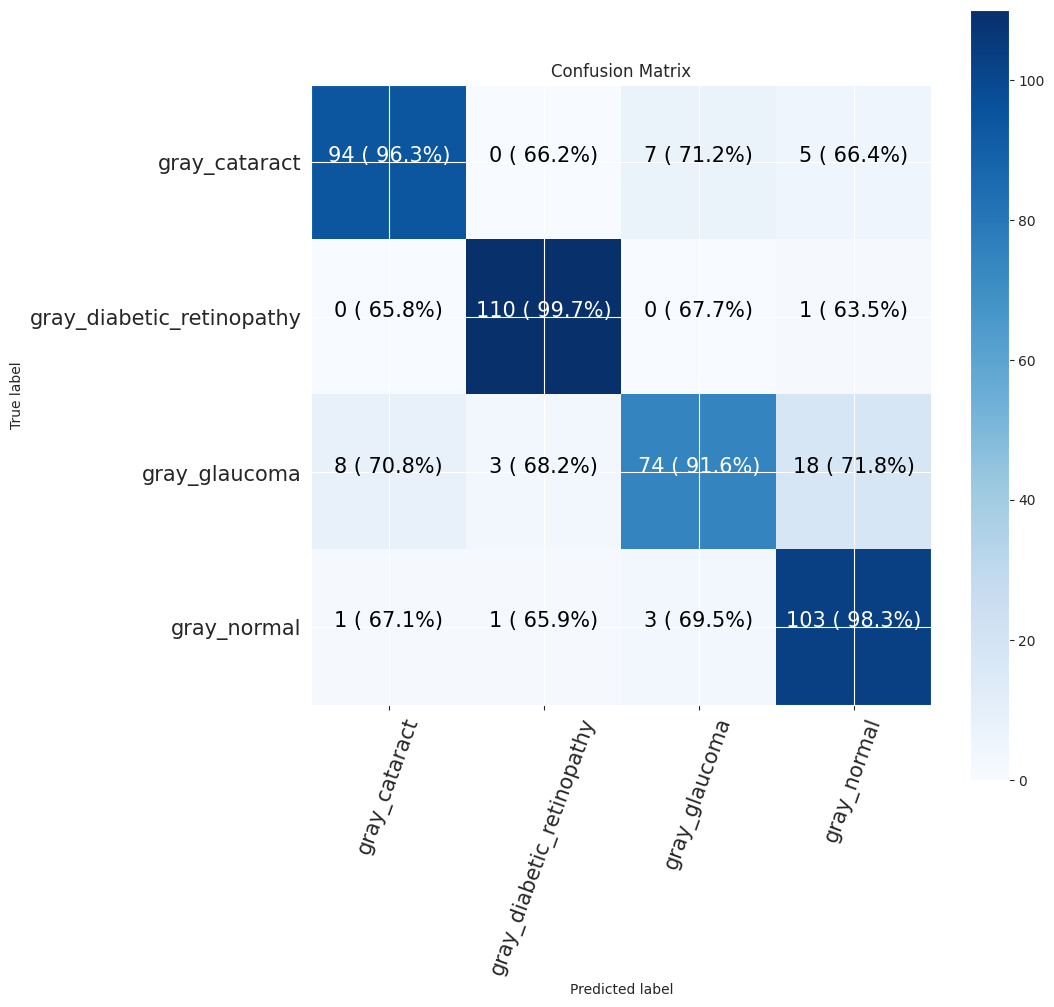

In [18]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


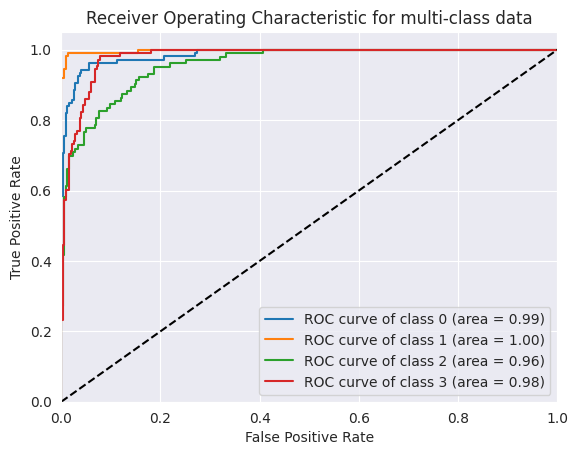

In [19]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [20]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

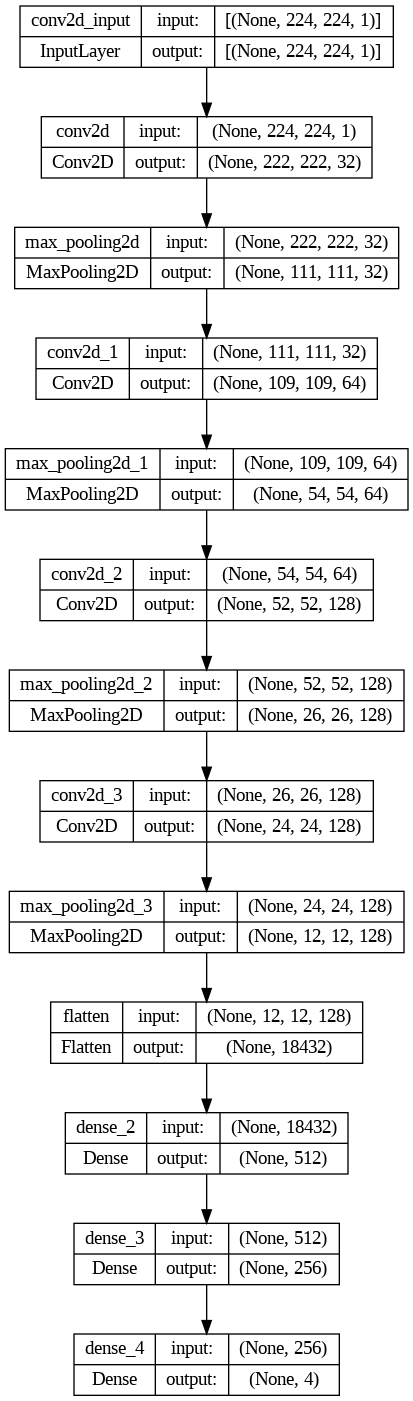

In [21]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [22]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [23]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 9s 26ms/step - loss: 1.8820 - accuracy: 0.5645 - val_loss: 0.7214 - val_accuracy: 0.6722 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 5s 21ms/step - loss: 0.6453 - accuracy: 0.7206 - val_loss: 0.5294 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 5s 21ms/step - loss: 0.5369 - accuracy: 0.7802 - val_loss: 0.5000 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 5s 21ms/step - loss: 0.4531 - accuracy: 0.8182 - val_loss: 0.4786 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 5s 22ms/step - loss: 0.3956 - accuracy: 0.8427 - val_loss: 0.4496 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 5s 21ms/step - loss: 0.4135 - accuracy: 0.8353 - val_loss: 0.4006 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 7/20
212/212 [==============================] - 5s 21ms/st

CNN Evaluation

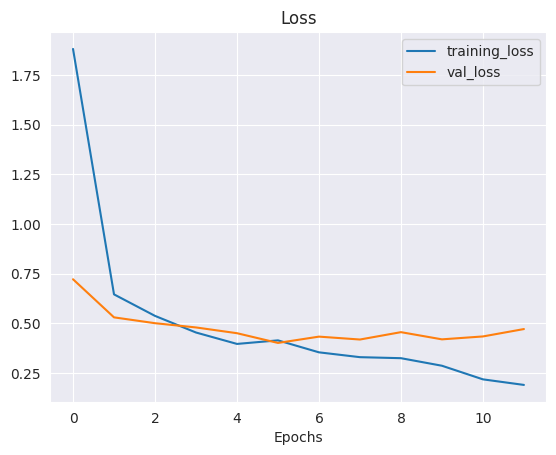

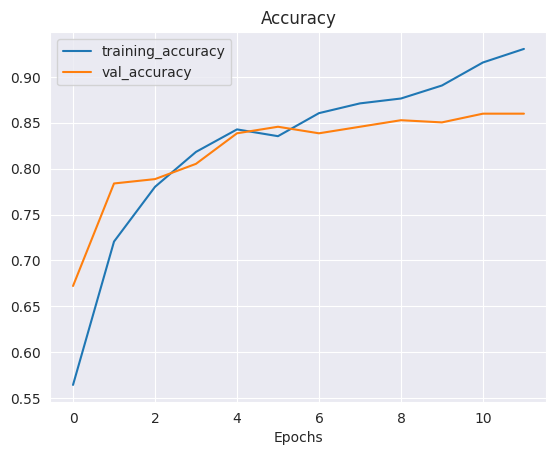

In [24]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       106
           1       1.00      1.00      1.00       111
           2       0.77      0.70      0.73       103
           3       0.81      0.85      0.83       108

    accuracy                           0.86       428
   macro avg       0.85      0.85      0.85       428
weighted avg       0.85      0.86      0.85       428

Specificity: [0.27002967359050445, 0.3501577287066246, 0.20224719101123595, 0.27380952380952384]
Mean Squared Error: : 0.11556857824325562
The average AUC-ROC is 0.9668046250883678


[0.9529780564263323,
 0.6656151419558359,
 0.7155688622754491,
 0.6751592356687898,
 0.6520376175548589,
 1.0,
 0.6676646706586826,
 0.6464968152866242,
 0.7178683385579937,
 0.6750788643533123,
 0.907185628742515,
 0.7292993630573248,
 0.677115987460815,
 0.6593059936908517,
 0.7095808383233533,
 0.9490445859872612]

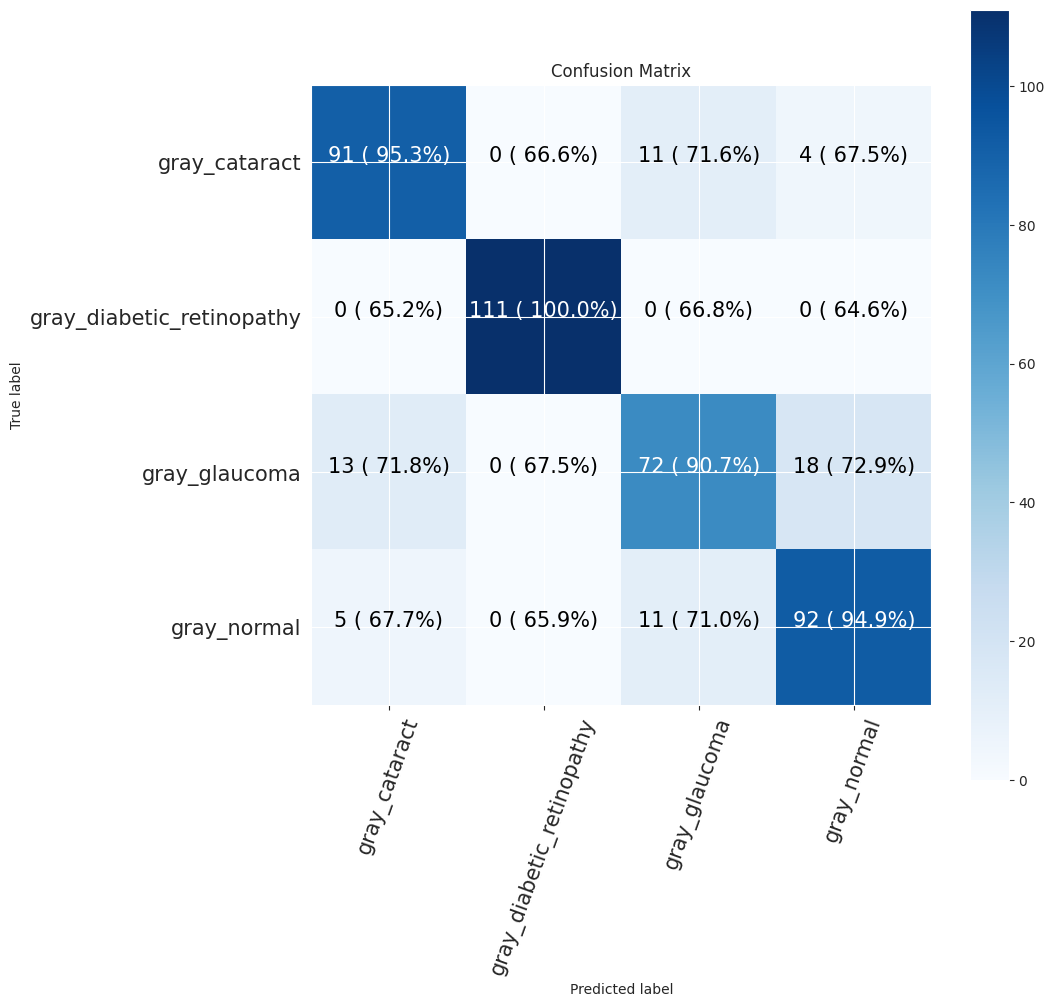

In [25]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


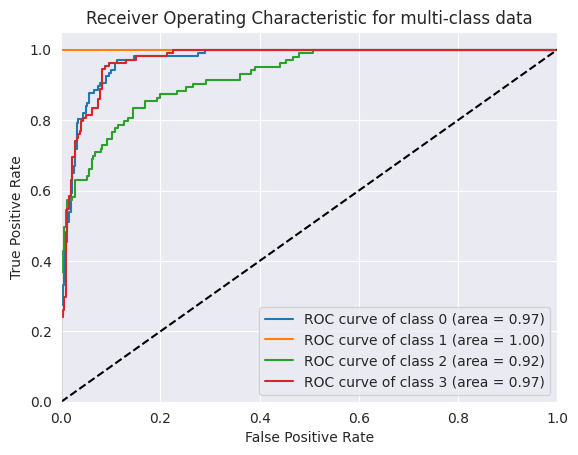

In [26]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [27]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 4)                 4100 

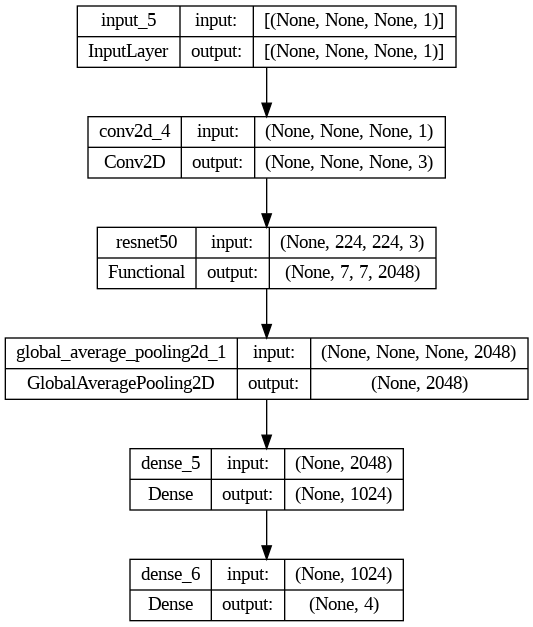

In [28]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [29]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [30]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 41s 157ms/step - loss: 0.6369 - accuracy: 0.7698 - val_loss: 0.3997 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 29s 136ms/step - loss: 0.3858 - accuracy: 0.8542 - val_loss: 0.3082 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 29s 135ms/step - loss: 0.3017 - accuracy: 0.8796 - val_loss: 0.4262 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 29s 135ms/step - loss: 0.2813 - accuracy: 0.8879 - val_loss: 0.2925 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 29s 136ms/step - loss: 0.2718 - accuracy: 0.8911 - val_loss: 0.2604 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 29s 135ms/step - loss: 0.2198 - accuracy: 0.9135 - val_loss: 0.3800 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       106
           1       0.99      1.00      1.00       111
           2       0.85      0.82      0.83       103
           3       0.89      0.86      0.88       108

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.90      0.90      0.90       428

Specificity: [0.3009118541033435, 0.3501577287066246, 0.2441860465116279, 0.27761194029850744]
Mean Squared Error: : 0.10705398768186569
The average AUC-ROC is 0.9872816206825639


[0.9777777777777777,
 0.6645569620253164,
 0.6930091185410334,
 0.6790123456790124,
 0.6476190476190476,
 1.0,
 0.662613981762918,
 0.6574074074074074,
 0.7015873015873015,
 0.6772151898734177,
 0.9422492401215805,
 0.7098765432098766,
 0.6730158730158731,
 0.6582278481012658,
 0.7021276595744681,
 0.9537037037037037]

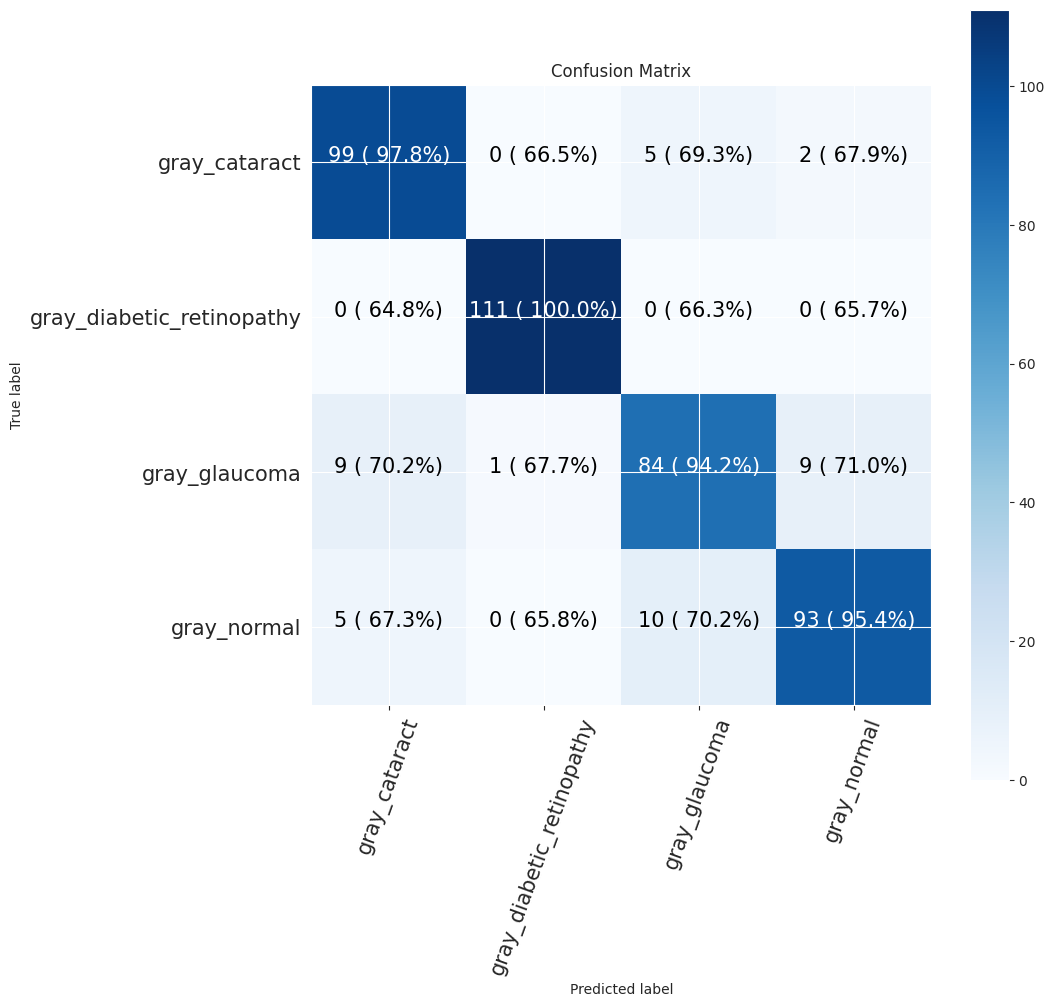

In [31]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


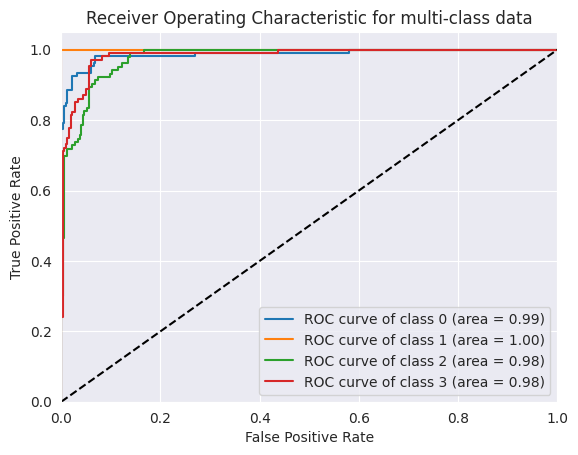

In [32]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [33]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 8s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 410

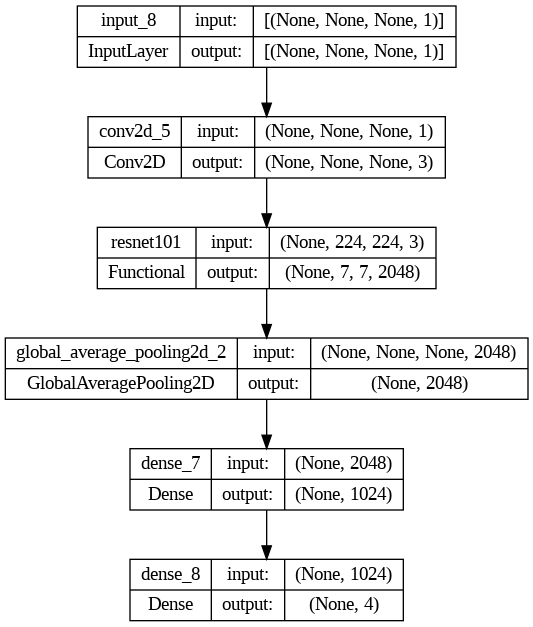

In [34]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [35]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [36]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 57s 232ms/step - loss: 0.6313 - accuracy: 0.7595 - val_loss: 0.5201 - val_accuracy: 0.7981 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 47s 221ms/step - loss: 0.3536 - accuracy: 0.8595 - val_loss: 0.3866 - val_accuracy: 0.8527 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 47s 222ms/step - loss: 0.3226 - accuracy: 0.8690 - val_loss: 0.3715 - val_accuracy: 0.8527 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 47s 222ms/step - loss: 0.2748 - accuracy: 0.8950 - val_loss: 0.3265 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 47s 222ms/step - loss: 0.2525 - accuracy: 0.9020 - val_loss: 0.3198 - val_accuracy: 0.8812 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 47s 222ms/step - loss: 0.2457 - accuracy: 0.9003 - val_loss: 0.4238 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 2s 82ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       106
           1       0.99      0.99      0.99       111
           2       0.79      0.85      0.82       103
           3       0.87      0.82      0.85       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.281437125748503, 0.34591194968553457, 0.25882352941176473, 0.26253687315634217]
Mean Squared Error: : 0.10758261382579803
The average AUC-ROC is 0.9826812999520229


[0.963076923076923,
 0.6656151419558359,
 0.689873417721519,
 0.6871165644171779,
 0.6584615384615384,
 0.9968454258675079,
 0.6487341772151899,
 0.6625766871165644,
 0.7015384615384616,
 0.6782334384858044,
 0.9525316455696202,
 0.7085889570552147,
 0.676923076923077,
 0.6593059936908517,
 0.7088607594936709,
 0.941717791411043]

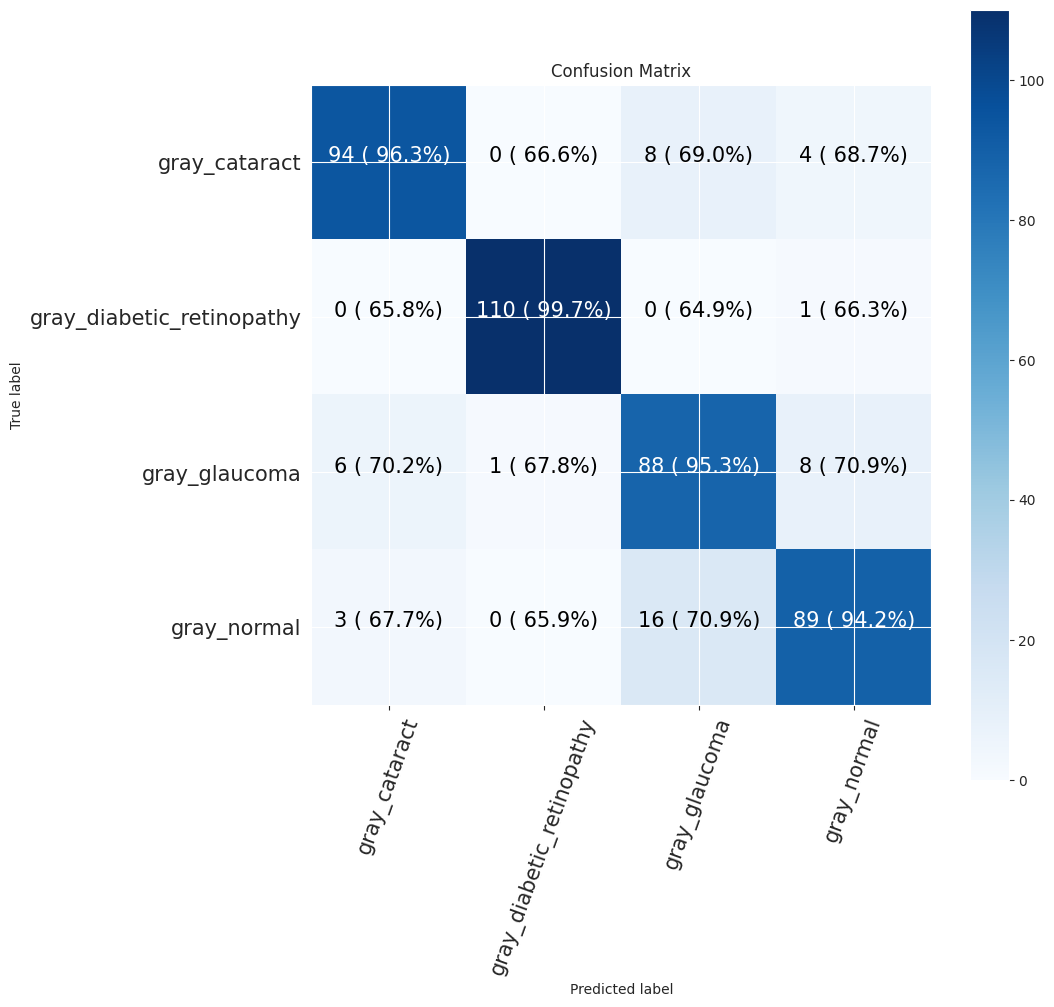

In [37]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


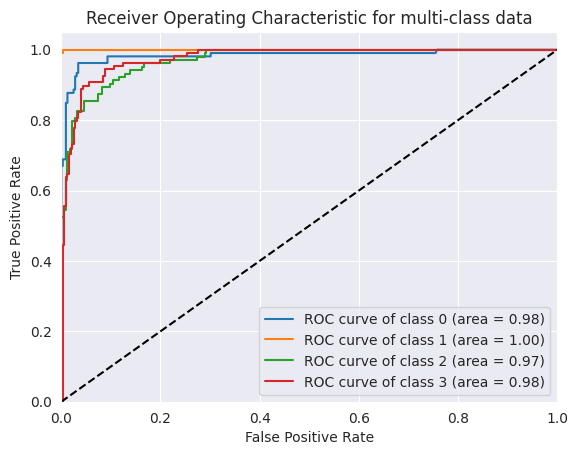

In [38]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [39]:
epoch = 20
batchsize = 32

In [40]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
# class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


In [41]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [42]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [43]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                           

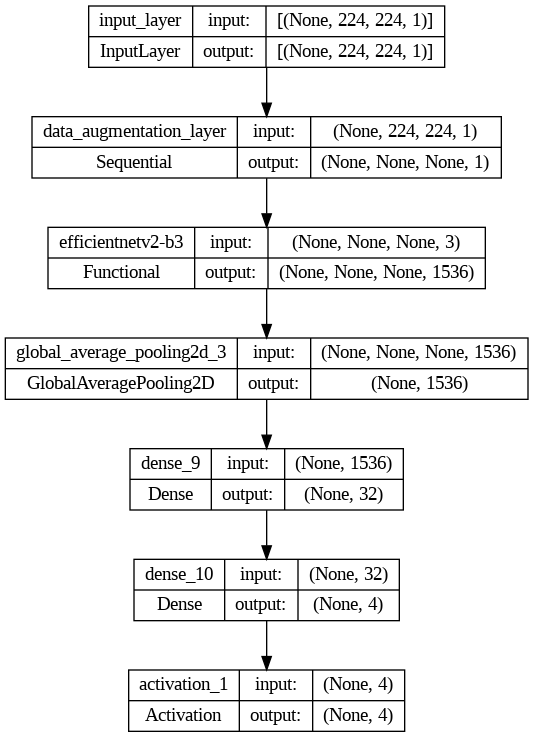

In [44]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [45]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [46]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 103s 858ms/step - loss: 0.7386 - accuracy: 0.6946 - val_loss: 0.6349 - val_accuracy: 0.7577 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 82s 772ms/step - loss: 0.5254 - accuracy: 0.7934 - val_loss: 0.5655 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 71s 665ms/step - loss: 0.4693 - accuracy: 0.8250 - val_loss: 0.4918 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 65s 611ms/step - loss: 0.4329 - accuracy: 0.8348 - val_loss: 0.4894 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 62s 582ms/step - loss: 0.4235 - accuracy: 0.8380 - val_loss: 0.4577 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 59s 555ms/step - loss: 0.3954 - accuracy: 0.8472 - val_loss: 0.5124 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 7/20
106/106 [==============================]

EfficientNetV2B3 Evaluation

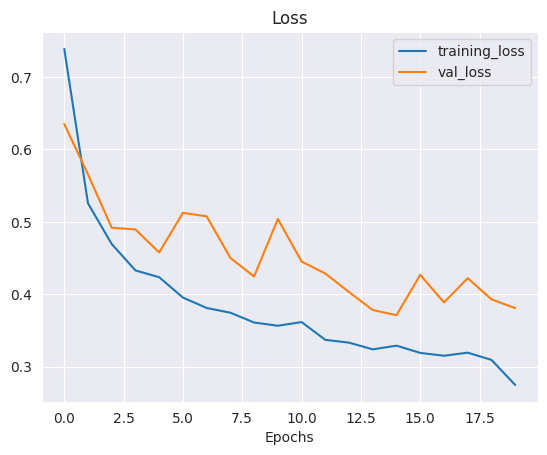

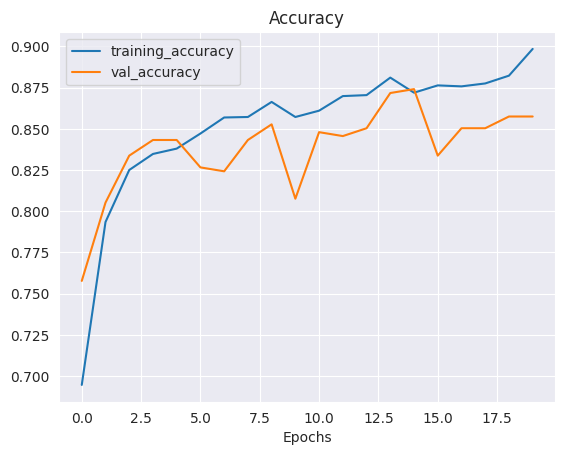

In [47]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 77ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       106
           1       0.98      0.96      0.97       111
           2       0.89      0.69      0.78       103
           3       0.80      0.95      0.87       108

    accuracy                           0.89       428
   macro avg       0.89      0.88      0.88       428
weighted avg       0.89      0.89      0.88       428

Specificity: [0.296969696969697, 0.3333333333333333, 0.19887955182072828, 0.3169230769230769]
Mean Squared Error: : 0.11322127282619476
The average AUC-ROC is 0.9818982871646625


[0.9747634069400631,
 0.6677115987460815,
 0.7126436781609196,
 0.6533333333333333,
 0.6498422712933754,
 0.987460815047022,
 0.6810344827586207,
 0.6433333333333333,
 0.7129337539432177,
 0.6802507836990596,
 0.9080459770114943,
 0.72,
 0.6624605678233438,
 0.664576802507837,
 0.6982758620689655,
 0.9833333333333333]

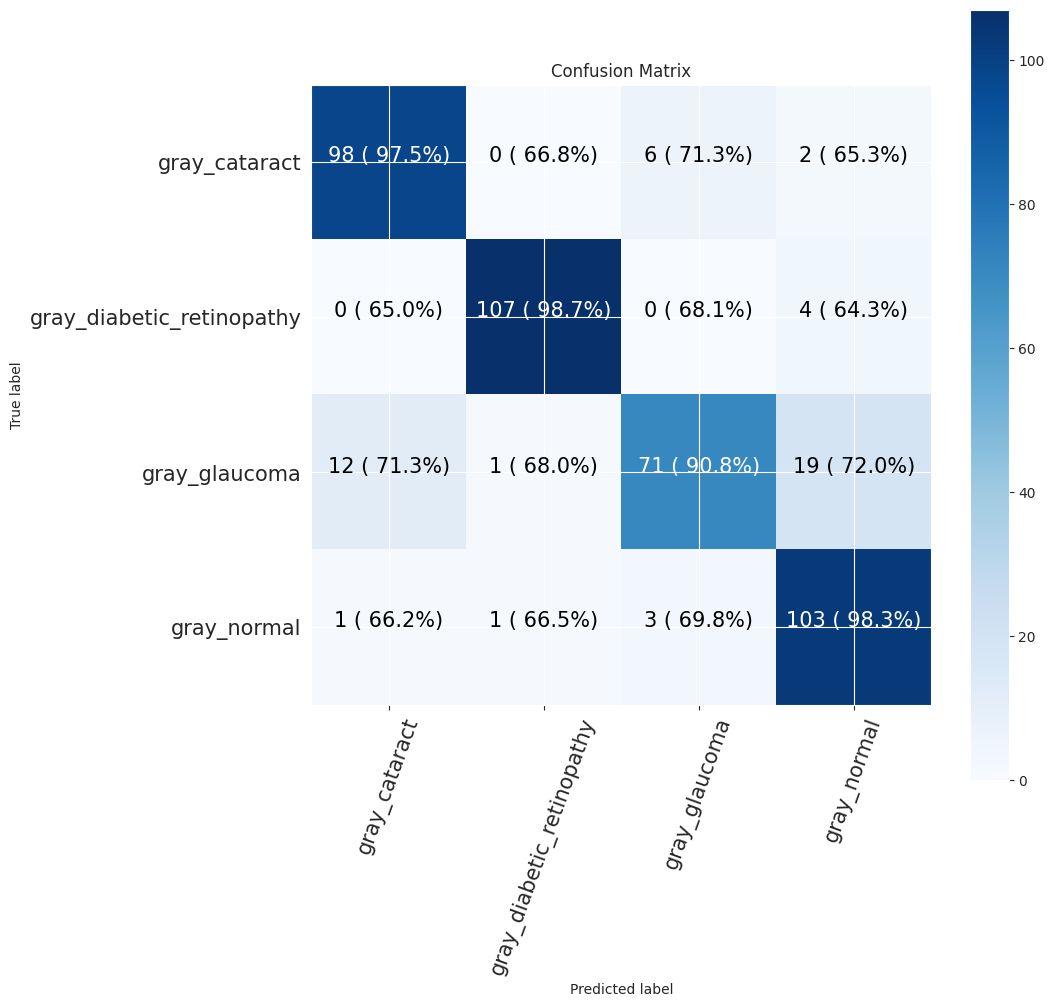

In [48]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


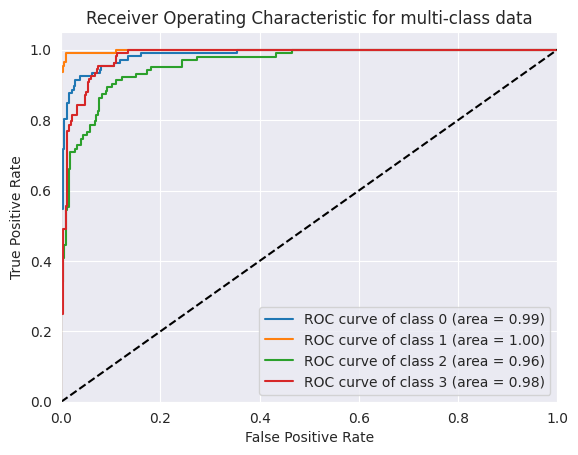

In [49]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [50]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

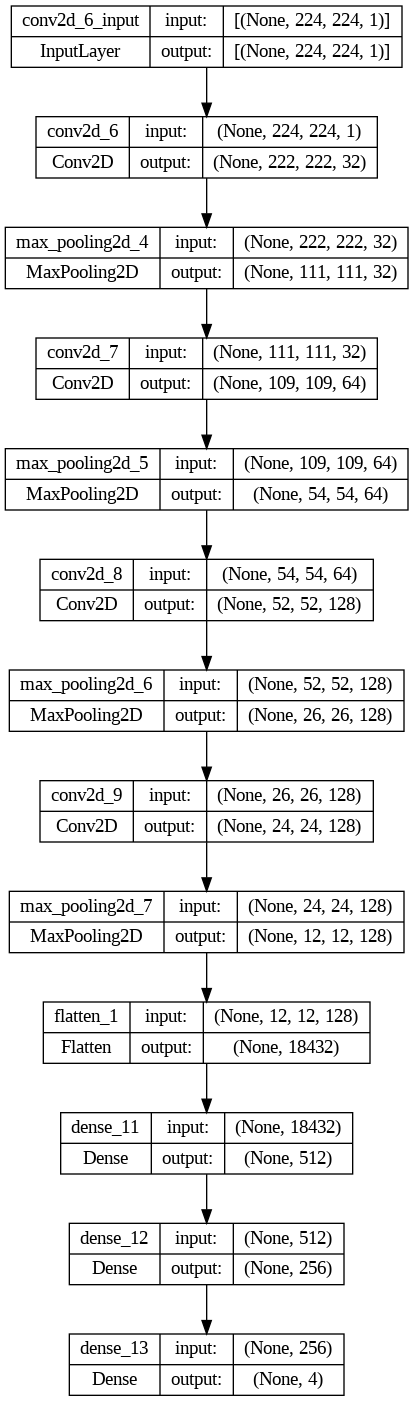

In [51]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [52]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [53]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 8s 47ms/step - loss: 3.9171 - accuracy: 0.5471 - val_loss: 0.8482 - val_accuracy: 0.6247 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 4s 35ms/step - loss: 0.6722 - accuracy: 0.7055 - val_loss: 0.5885 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 4s 35ms/step - loss: 0.5862 - accuracy: 0.7395 - val_loss: 0.5461 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 4s 35ms/step - loss: 0.5360 - accuracy: 0.7740 - val_loss: 0.5994 - val_accuracy: 0.7530 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 4s 35ms/step - loss: 0.9506 - accuracy: 0.6037 - val_loss: 0.8200 - val_accuracy: 0.5249 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 4s 35ms/step - loss: 0.7305 - accuracy: 0.6456 - val_loss: 0.7148 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 7/20
106/106 [==============================] - 4s 35ms/st

CNN Evaluation

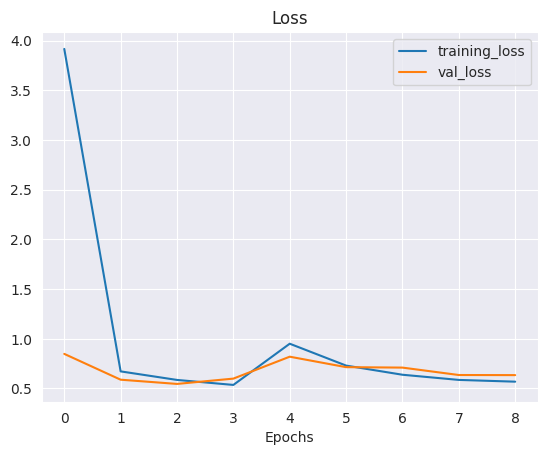

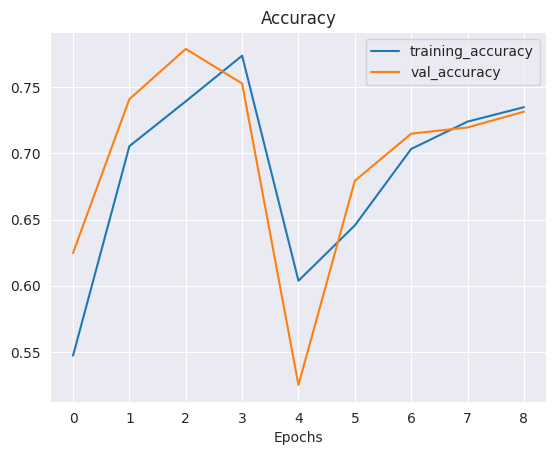

In [54]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.78      0.67       106
           1       1.00      0.98      0.99       111
           2       0.69      0.19      0.30       103
           3       0.68      0.94      0.79       108

    accuracy                           0.73       428
   macro avg       0.74      0.73      0.69       428
weighted avg       0.74      0.73      0.70       428

Specificity: [0.24057971014492754, 0.34169278996865204, 0.049019607843137254, 0.3128834355828221]
Mean Squared Error: : 0.1400526612997055
The average AUC-ROC is 0.9036265261023906


[0.9198606271777003,
 0.6677115987460815,
 0.7443609022556391,
 0.6881720430107527,
 0.6132404181184669,
 0.9937304075235109,
 0.7243107769423559,
 0.6057347670250897,
 0.8362369337979094,
 0.677115987460815,
 0.7919799498746867,
 0.7275985663082437,
 0.6306620209059234,
 0.6614420062695925,
 0.7393483709273183,
 0.978494623655914]

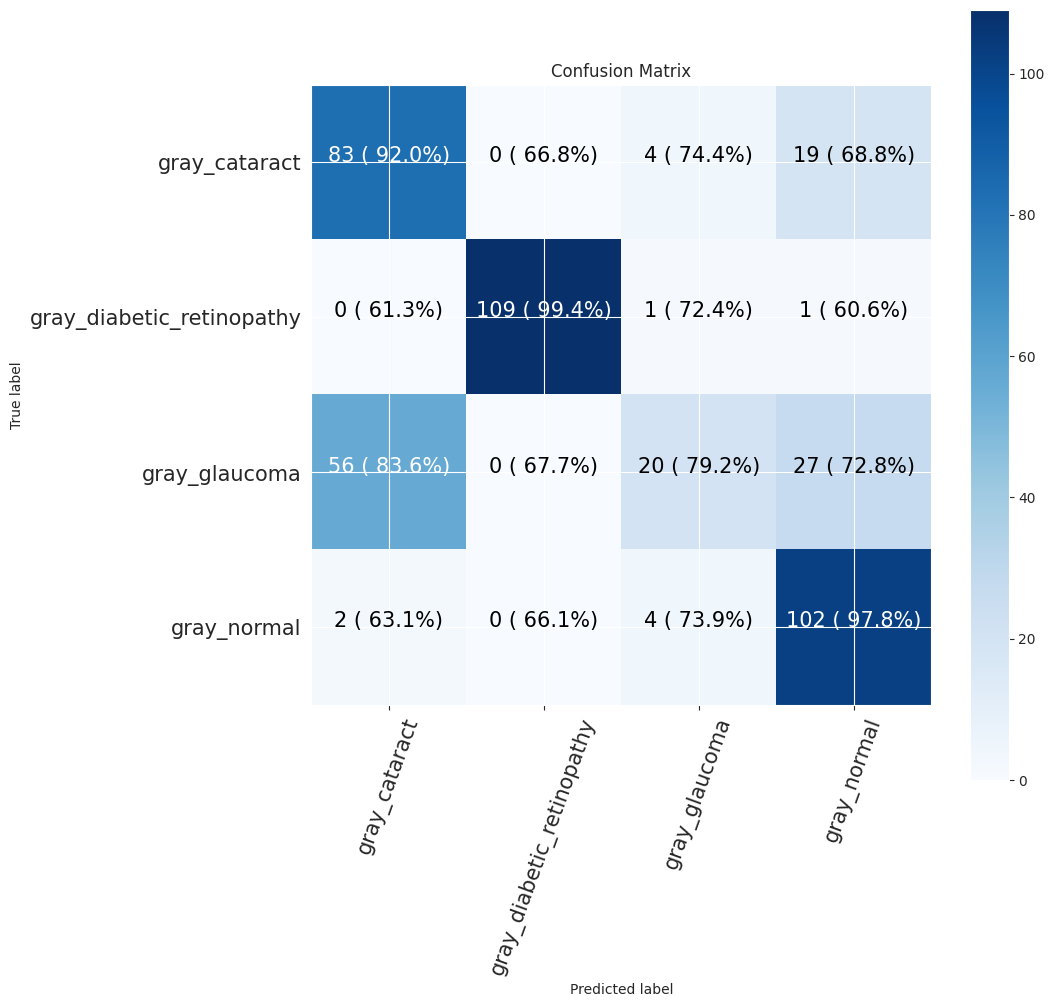

In [55]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


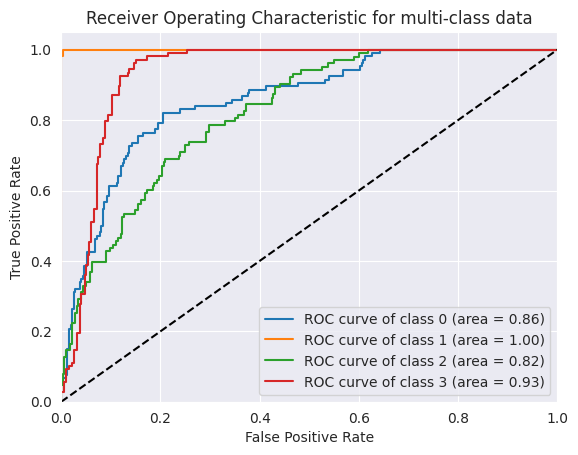

In [56]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [57]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 4)                 4100      
                                                           

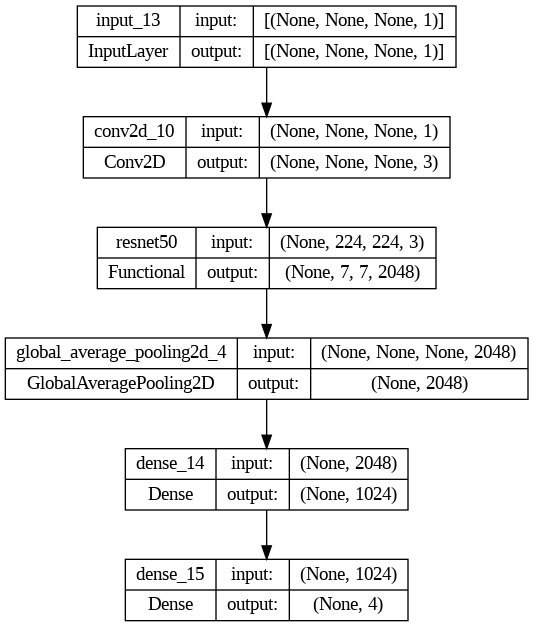

In [58]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [59]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [60]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 40s 302ms/step - loss: 0.7495 - accuracy: 0.7583 - val_loss: 0.4359 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 27s 255ms/step - loss: 0.3600 - accuracy: 0.8678 - val_loss: 0.3809 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 27s 255ms/step - loss: 0.2972 - accuracy: 0.8911 - val_loss: 0.3283 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 27s 255ms/step - loss: 0.2930 - accuracy: 0.8926 - val_loss: 0.4000 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 27s 255ms/step - loss: 0.2268 - accuracy: 0.9147 - val_loss: 0.3394 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 27s 255ms/step - loss: 0.2125 - accuracy: 0.9168 - val_loss: 0.3493 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 89ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       106
           1       0.98      1.00      0.99       111
           2       0.84      0.82      0.83       103
           3       0.87      0.90      0.89       108

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.90      0.90      0.90       428

Specificity: [0.2852852852852853, 0.3501577287066246, 0.2441860465116279, 0.2930513595166163]
Mean Squared Error: : 0.10676383227109909
The average AUC-ROC is 0.9883790342634017


[0.9660493827160493,
 0.6634920634920635,
 0.7012195121951219,
 0.6750788643533123,
 0.6574074074074074,
 1.0,
 0.6615853658536586,
 0.6498422712933754,
 0.7006172839506173,
 0.6793650793650794,
 0.9420731707317073,
 0.7097791798107256,
 0.6759259259259259,
 0.6571428571428571,
 0.6951219512195121,
 0.9652996845425867]

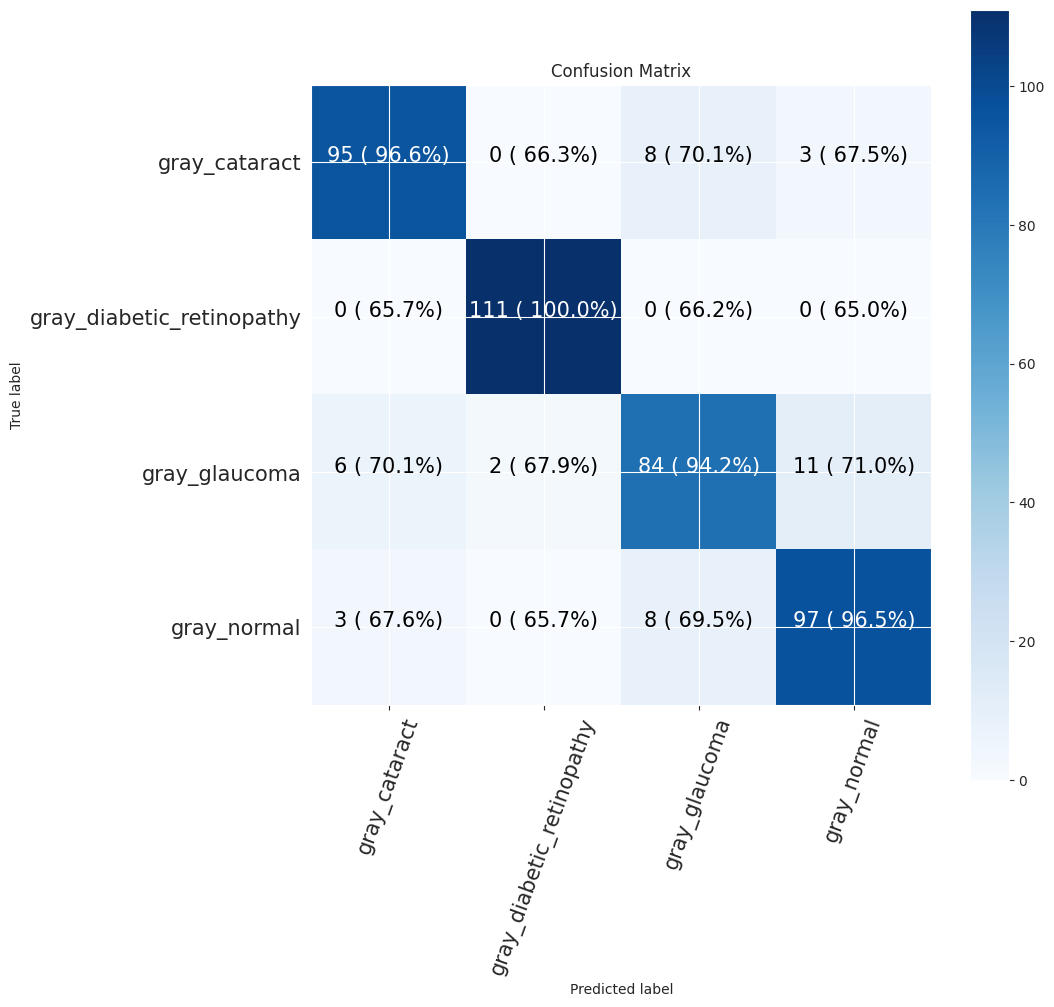

In [61]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


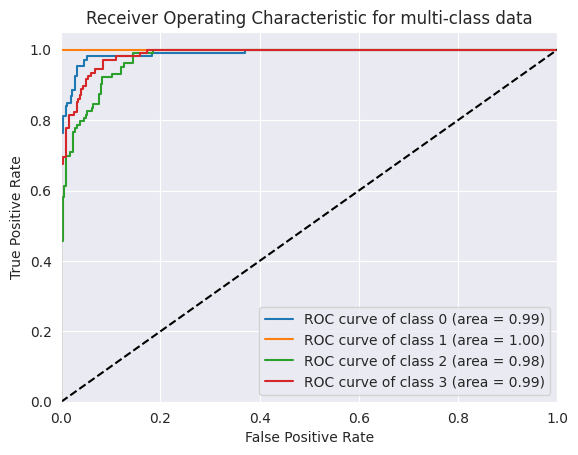

In [62]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [63]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 4)                 4100      
                                                           

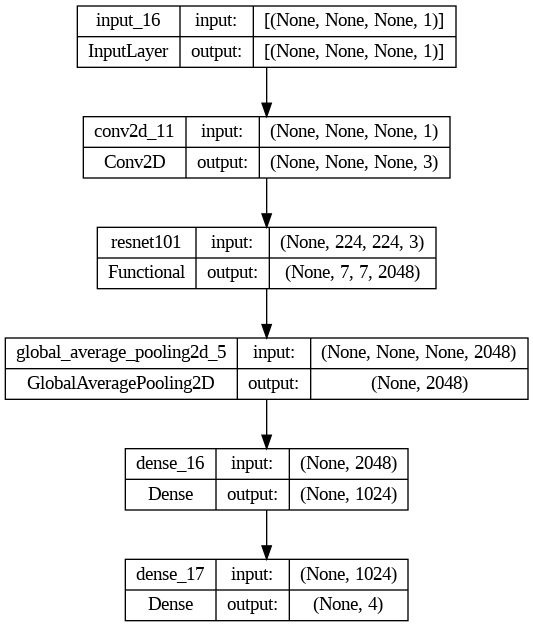

In [64]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [65]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [66]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 54s 441ms/step - loss: 0.8493 - accuracy: 0.7138 - val_loss: 0.5252 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 44s 419ms/step - loss: 0.4249 - accuracy: 0.8321 - val_loss: 0.5284 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 45s 420ms/step - loss: 0.3387 - accuracy: 0.8675 - val_loss: 0.3298 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 45s 419ms/step - loss: 0.3048 - accuracy: 0.8799 - val_loss: 0.3284 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 45s 420ms/step - loss: 0.3001 - accuracy: 0.8885 - val_loss: 0.4481 - val_accuracy: 0.8147 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 45s 420ms/step - loss: 0.2699 - accuracy: 0.8985 - val_loss: 0.3376 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 2s 152ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       106
           1       0.99      0.98      0.99       111
           2       0.85      0.78      0.81       103
           3       0.85      0.88      0.86       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.296969696969697, 0.34169278996865204, 0.22988505747126436, 0.2852852852852853]
Mean Squared Error: : 0.10956738144159317
The average AUC-ROC is 0.9825386350704604


[0.9746835443037974,
 0.6666666666666666,
 0.6976047904191617,
 0.6740506329113924,
 0.6487341772151899,
 0.9937106918238994,
 0.6676646706586826,
 0.6550632911392406,
 0.7088607594936709,
 0.6761006289308176,
 0.9311377245508982,
 0.7120253164556962,
 0.6677215189873418,
 0.6635220125786163,
 0.7035928143712575,
 0.9588607594936709]

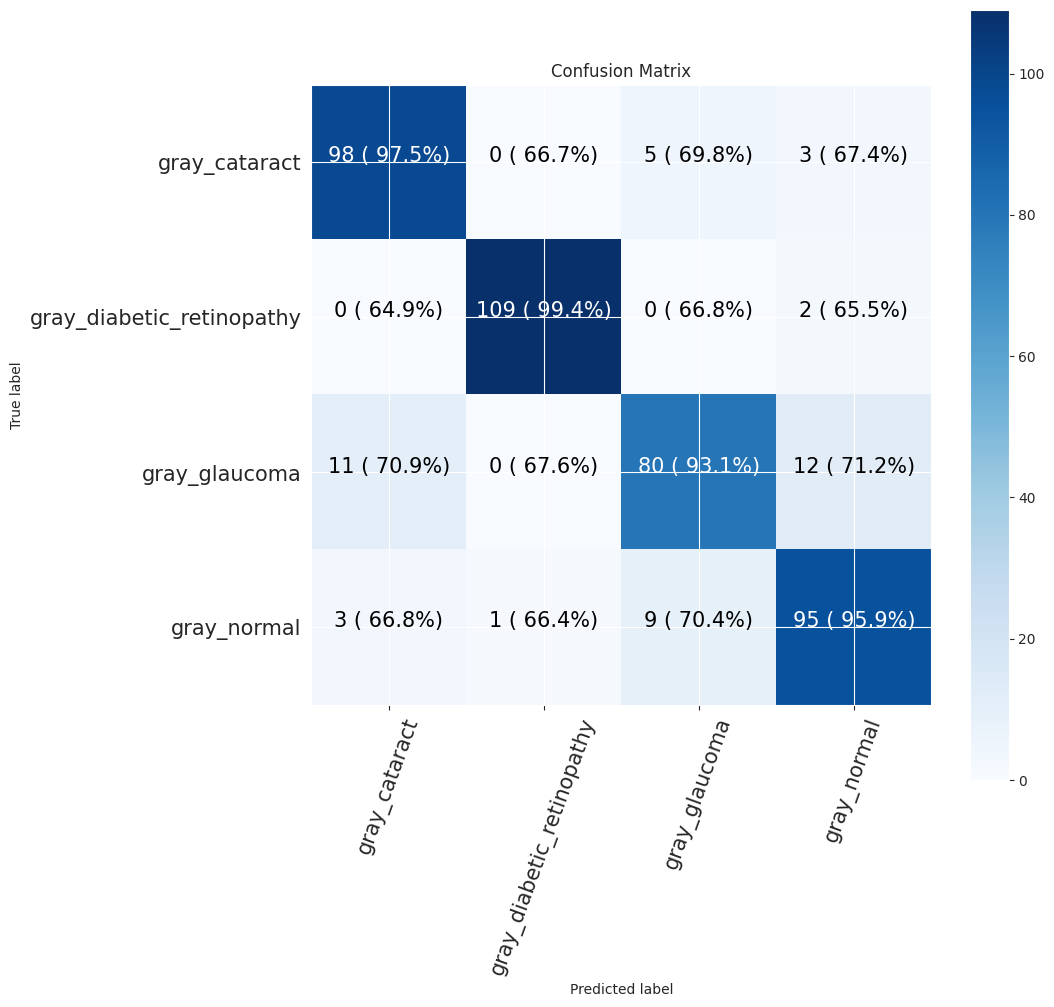

In [67]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


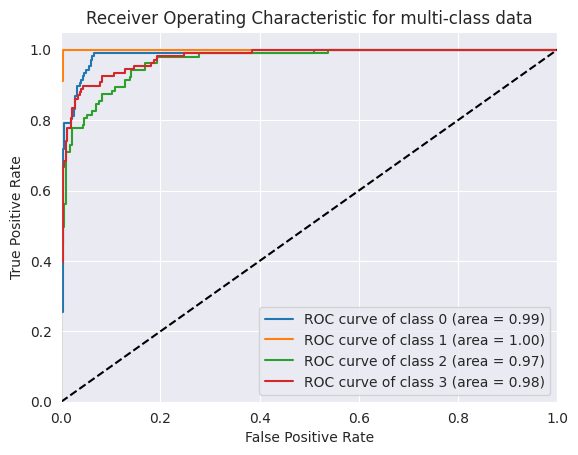

In [68]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [69]:
epoch = 20
batchsize = 64

In [70]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
# class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


In [71]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [72]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [73]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_6  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 32)                49184     
                                                           

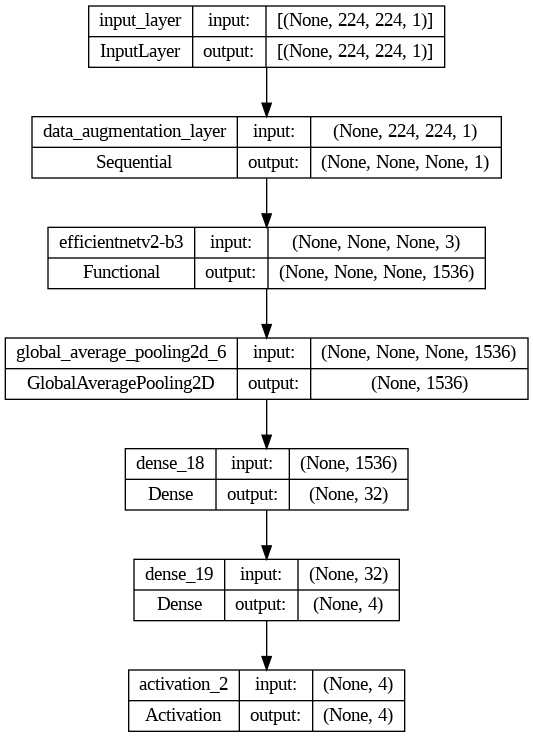

In [74]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [75]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [76]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 100s 2s/step - loss: 0.7609 - accuracy: 0.6967 - val_loss: 0.6630 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 76s 1s/step - loss: 0.5535 - accuracy: 0.7875 - val_loss: 0.5215 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 73s 1s/step - loss: 0.4855 - accuracy: 0.8150 - val_loss: 0.5193 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 70s 1s/step - loss: 0.4399 - accuracy: 0.8398 - val_loss: 0.4978 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 70s 1s/step - loss: 0.4186 - accuracy: 0.8445 - val_loss: 0.4640 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 64s 1s/step - loss: 0.4256 - accuracy: 0.8351 - val_loss: 0.4403 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 65s 1s/step - loss: 0.3823 - 

EfficientNetV2B3 Evaluation

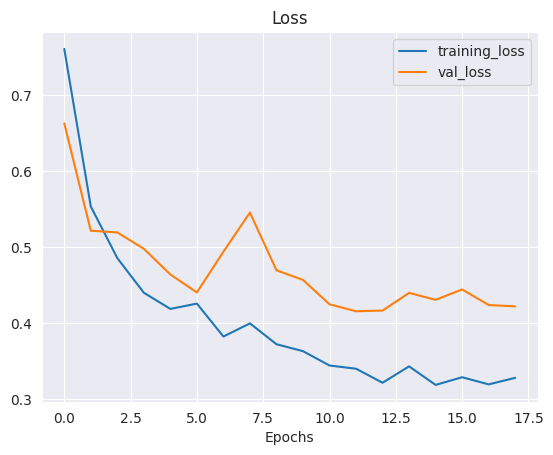

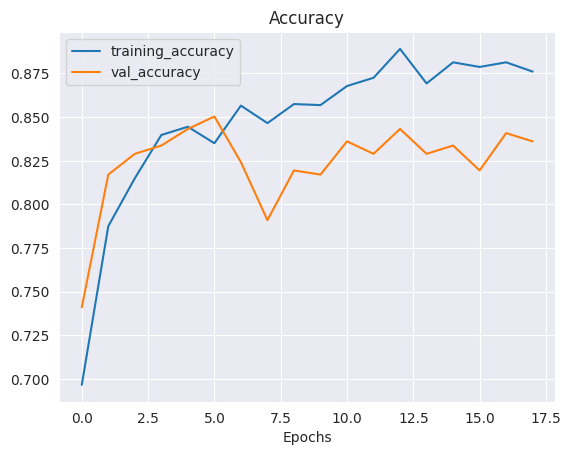

In [77]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 146ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       106
           1       0.98      0.96      0.97       111
           2       0.92      0.67      0.78       103
           3       0.79      0.96      0.87       108

    accuracy                           0.88       428
   macro avg       0.89      0.88      0.88       428
weighted avg       0.89      0.88      0.88       428

Specificity: [0.296969696969697, 0.3333333333333333, 0.19220055710306408, 0.32098765432098764]
Mean Squared Error: : 0.11526429653167725
The average AUC-ROC is 0.9787548327520137


[0.9746835443037974,
 0.6677115987460815,
 0.7110481586402266,
 0.6554054054054054,
 0.6487341772151899,
 0.987460815047022,
 0.6855524079320113,
 0.6385135135135135,
 0.7120253164556962,
 0.6833855799373041,
 0.9036827195467422,
 0.7195945945945946,
 0.6645569620253164,
 0.6614420062695925,
 0.6997167138810199,
 0.9864864864864865]

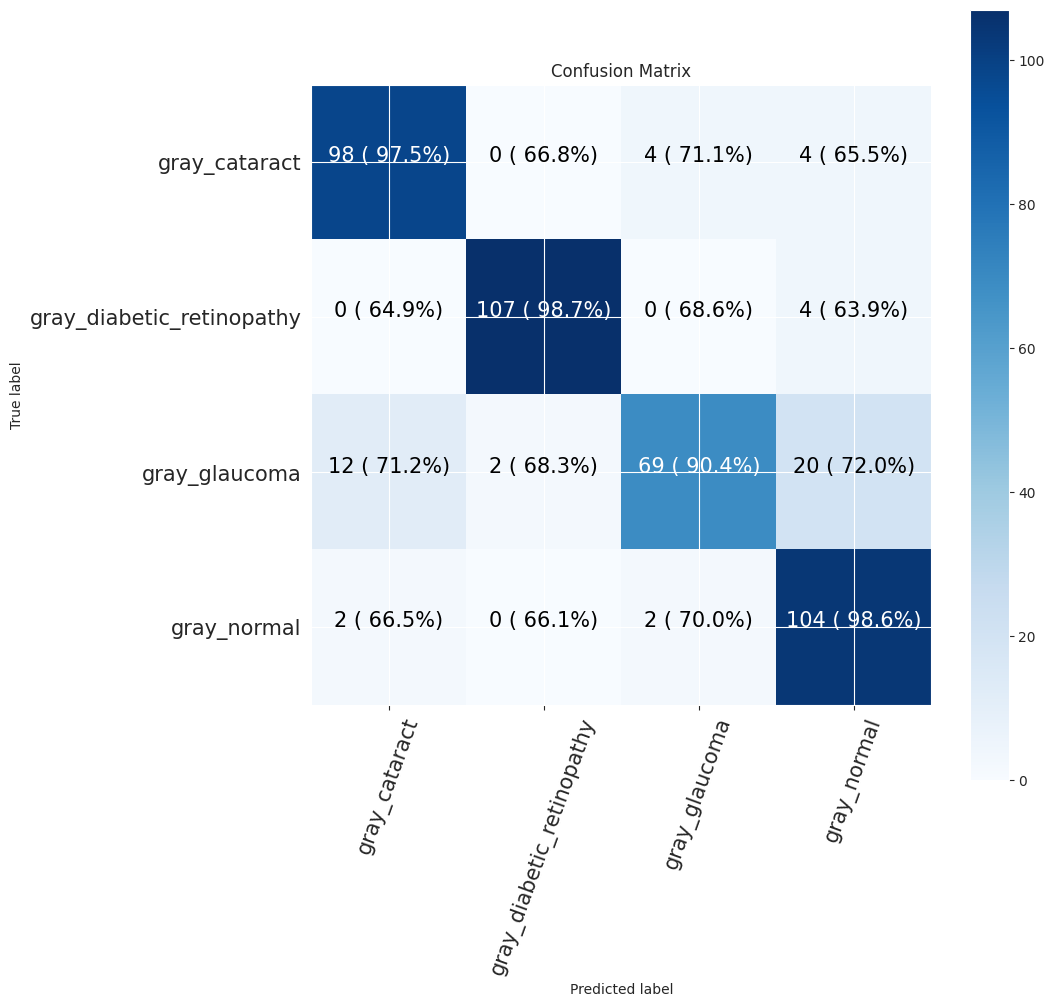

In [78]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


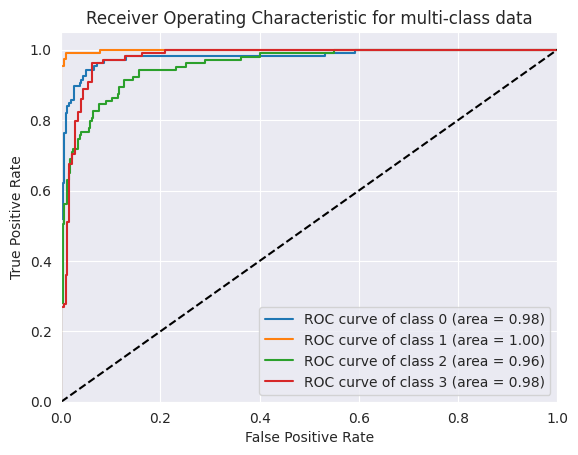

In [79]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [80]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

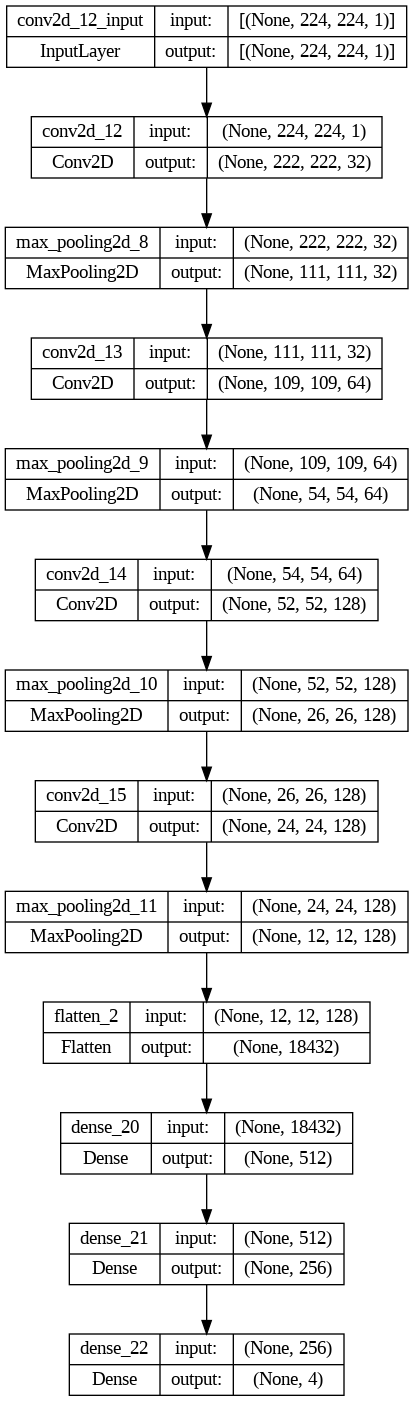

In [81]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [82]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [83]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 11s 121ms/step - loss: 7.7236 - accuracy: 0.4636 - val_loss: 1.0834 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 4s 66ms/step - loss: 0.9294 - accuracy: 0.6129 - val_loss: 0.7247 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 4s 66ms/step - loss: 0.6510 - accuracy: 0.7279 - val_loss: 0.7255 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 4s 66ms/step - loss: 0.5713 - accuracy: 0.7610 - val_loss: 0.5977 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 4s 66ms/step - loss: 0.5305 - accuracy: 0.7828 - val_loss: 0.6642 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 4s 65ms/step - loss: 0.4655 - accuracy: 0.8100 - val_loss: 0.6238 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 4s 66ms/step - loss: 0

CNN Evaluation

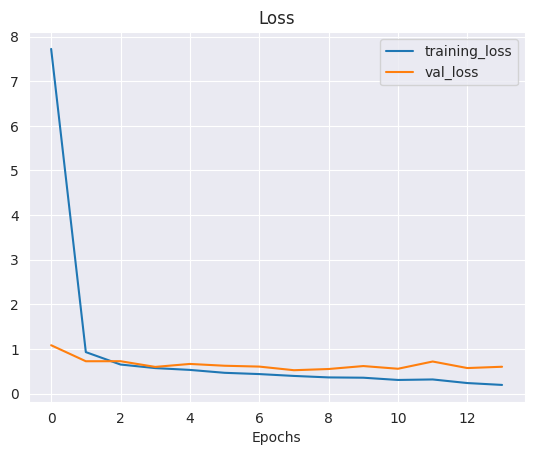

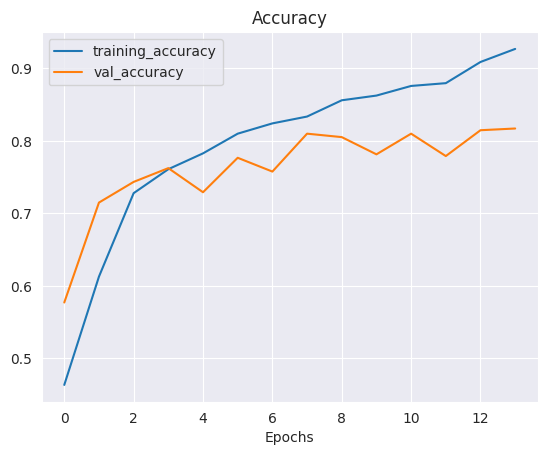

In [84]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       106
           1       0.97      0.98      0.98       111
           2       0.67      0.68      0.67       103
           3       0.77      0.80      0.78       108

    accuracy                           0.81       428
   macro avg       0.81      0.81      0.81       428
weighted avg       0.81      0.81      0.81       428

Specificity: [0.2334293948126801, 0.34169278996865204, 0.19553072625698323, 0.25146198830409355]
Mean Squared Error: : 0.12229324877262115
The average AUC-ROC is 0.9382661316804373


[0.9240121580547113,
 0.6677215189873418,
 0.7244582043343654,
 0.6867088607594937,
 0.662613981762918,
 0.9936708860759493,
 0.6594427244582043,
 0.6518987341772152,
 0.7264437689969605,
 0.680379746835443,
 0.8978328173374613,
 0.7310126582278481,
 0.6869300911854104,
 0.6582278481012658,
 0.718266253869969,
 0.930379746835443]

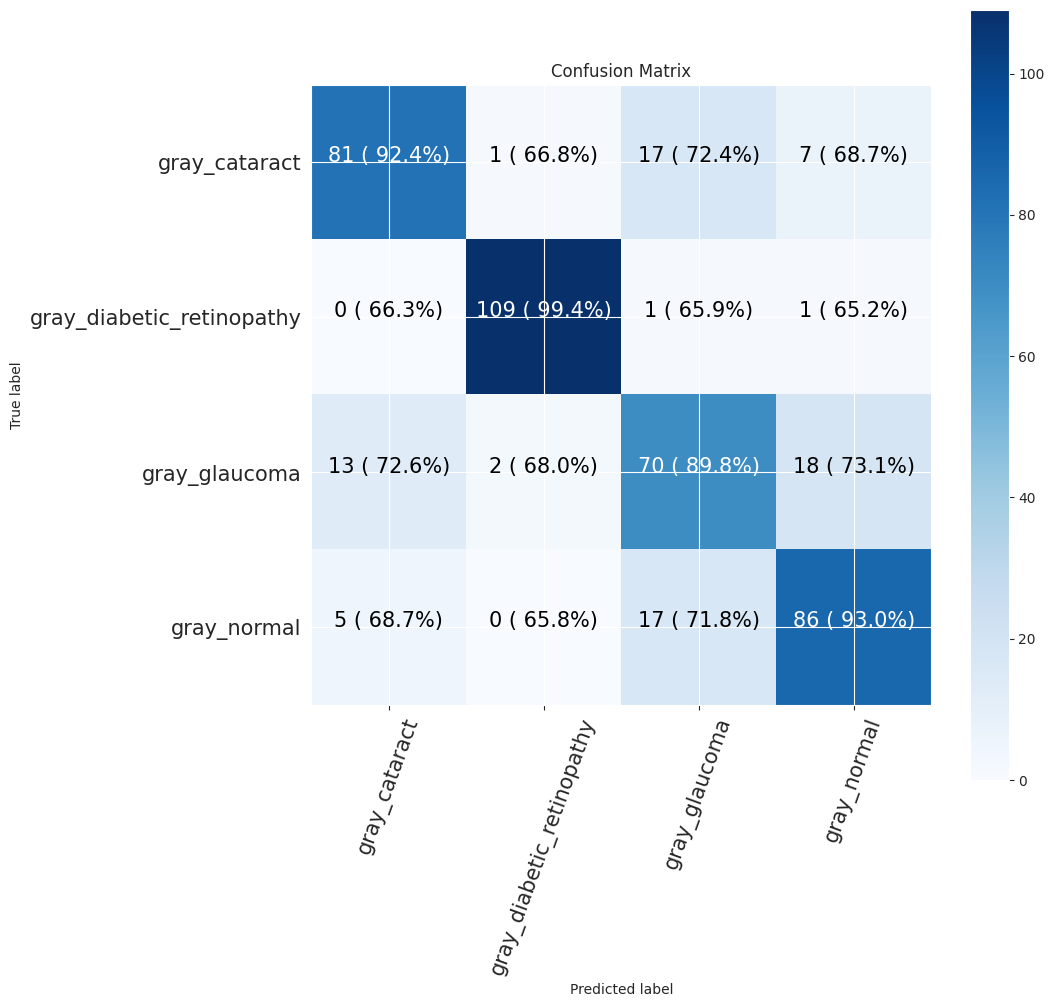

In [85]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


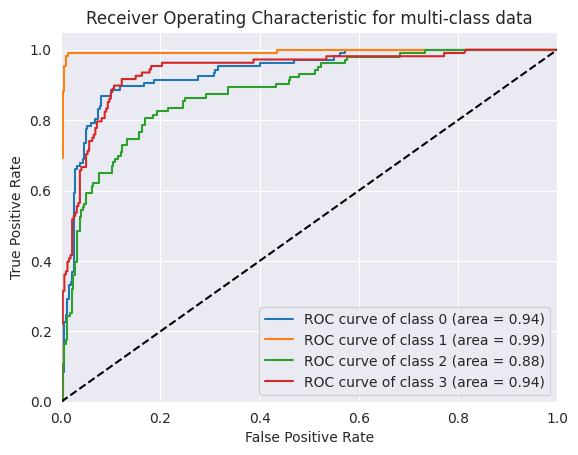

In [86]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [87]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_24 (Dense)            (None, 4)                 4100      
                                                           

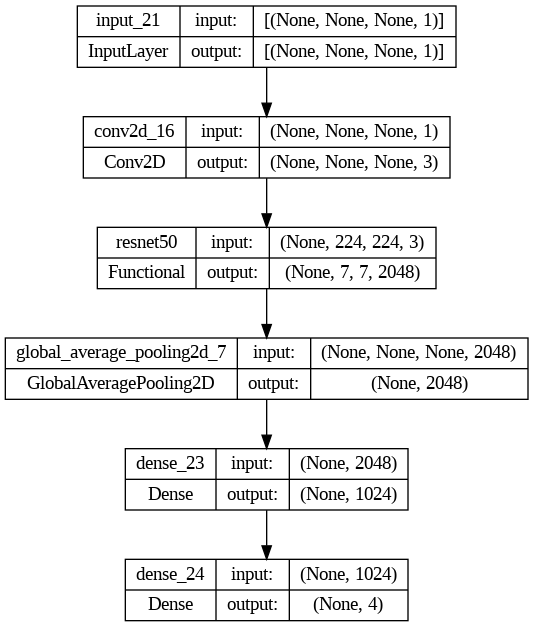

In [88]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [89]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [90]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 48s 692ms/step - loss: 1.0064 - accuracy: 0.7105 - val_loss: 0.4363 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 27s 495ms/step - loss: 0.3758 - accuracy: 0.8542 - val_loss: 0.3620 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 26s 494ms/step - loss: 0.3130 - accuracy: 0.8814 - val_loss: 0.3183 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 27s 497ms/step - loss: 0.2742 - accuracy: 0.8938 - val_loss: 0.3626 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 27s 496ms/step - loss: 0.2393 - accuracy: 0.9073 - val_loss: 0.3644 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 27s 496ms/step - loss: 0.2027 - accuracy: 0.9277 - val_loss: 0.2735 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 27s 496ms/st

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 174ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       106
           1       1.00      1.00      1.00       111
           2       0.84      0.84      0.84       103
           3       0.88      0.86      0.87       108

    accuracy                           0.91       428
   macro avg       0.91      0.91      0.91       428
weighted avg       0.91      0.91      0.91       428

Specificity: [0.3009118541033435, 0.3501577287066246, 0.25513196480938416, 0.27761194029850744]
Mean Squared Error: : 0.10715974122285843
The average AUC-ROC is 0.9873593264466903


[0.9781931464174455,
 0.6656151419558359,
 0.6820987654320988,
 0.6832298136645962,
 0.6542056074766355,
 1.0,
 0.6574074074074074,
 0.65527950310559,
 0.7009345794392523,
 0.6750788643533123,
 0.9506172839506173,
 0.7080745341614907,
 0.6666666666666666,
 0.6593059936908517,
 0.7098765432098766,
 0.953416149068323]

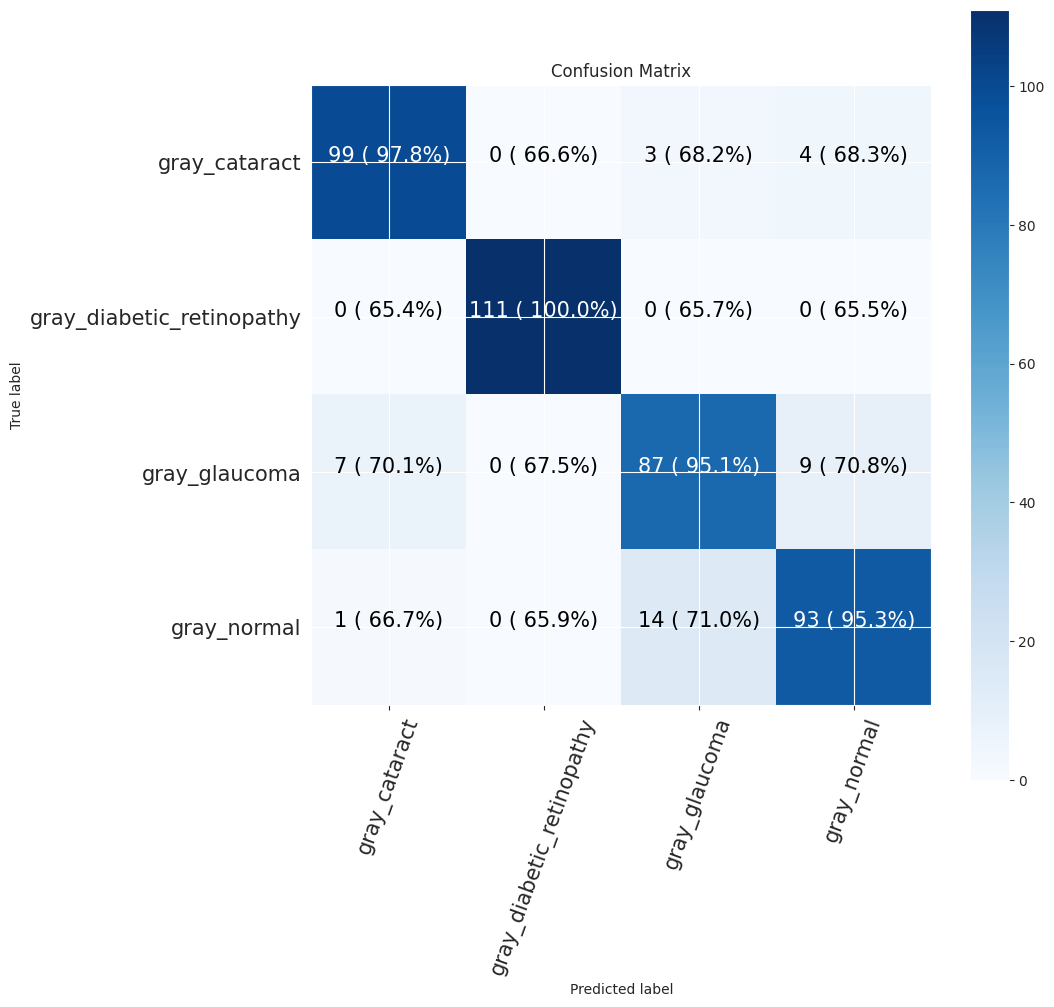

In [91]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


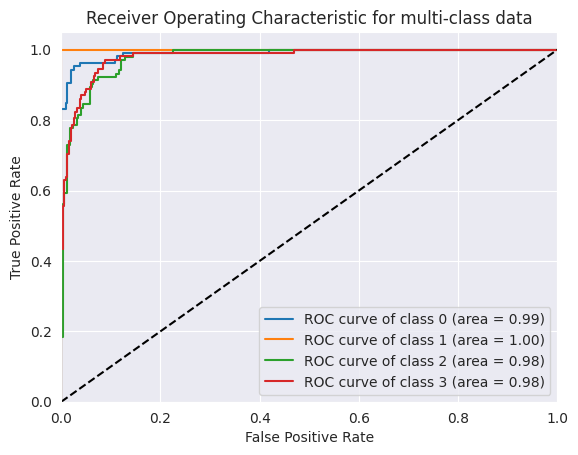

In [92]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [93]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 4)                 4100      
                                                           

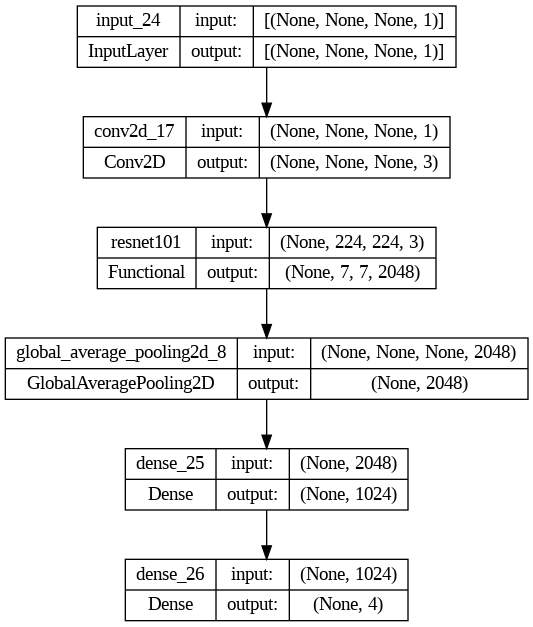

In [94]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [95]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [96]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 52s 851ms/step - loss: 0.8253 - accuracy: 0.7111 - val_loss: 0.5642 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 43s 804ms/step - loss: 0.3838 - accuracy: 0.8510 - val_loss: 0.4089 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 43s 807ms/step - loss: 0.3394 - accuracy: 0.8678 - val_loss: 0.3903 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 43s 807ms/step - loss: 0.2976 - accuracy: 0.8867 - val_loss: 0.3190 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 43s 807ms/step - loss: 0.2501 - accuracy: 0.9062 - val_loss: 0.3000 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 43s 808ms/step - loss: 0.2576 - accuracy: 0.9029 - val_loss: 0.3214 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 43s 808ms/st

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 2s 292ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       106
           1       1.00      1.00      1.00       111
           2       0.87      0.72      0.79       103
           3       0.85      0.88      0.86       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.308868501529052, 0.3501577287066246, 0.20903954802259886, 0.2852852852852853]
Mean Squared Error: : 0.11076604574918747
The average AUC-ROC is 0.9839873131112257


[0.9837662337662337,
 0.6656151419558359,
 0.6967930029154519,
 0.6740506329113924,
 0.6396103896103896,
 1.0,
 0.6763848396501457,
 0.6487341772151899,
 0.7142857142857143,
 0.6750788643533123,
 0.9154518950437318,
 0.7183544303797469,
 0.6623376623376623,
 0.6593059936908517,
 0.7113702623906706,
 0.9588607594936709]

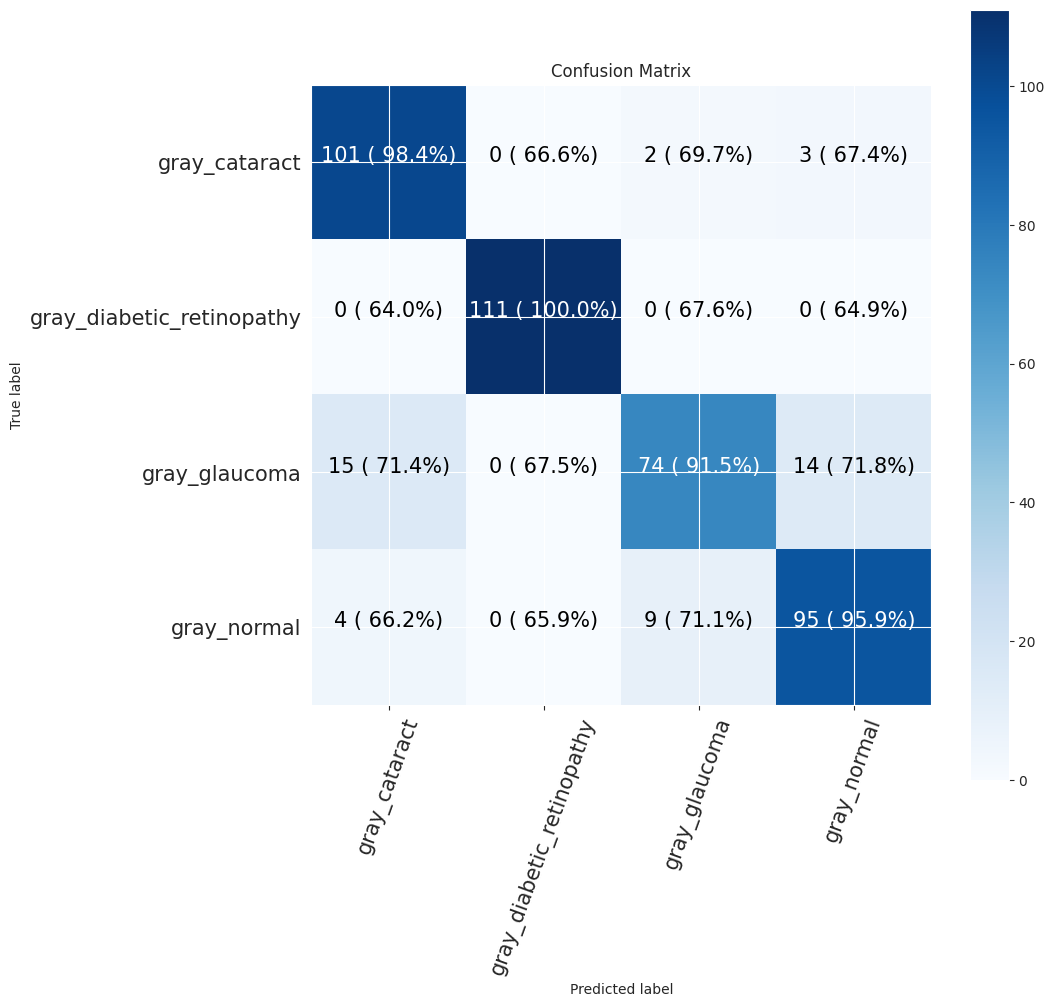

In [97]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


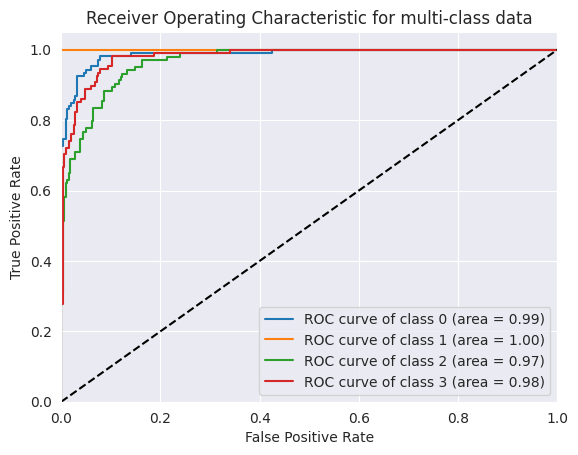

In [98]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()